# Linear Regression and Web Scraping project : predicting weekly stock returns  
- Target: weekly stock return  
- Stocks in the S and P 500 index  


In [43]:
import pandas as pd

from bs4 import BeautifulSoup
import requests
import time, os
from datetime import datetime

# 1. Grab list of S and P 500 table from wikipedia page, which includs the symbols we'll be using to navigate to the URL's we'll be scraping. Just use pd.read_html() this time.  

### Notes on this webpage: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
- "The Standard and Poor's 500, or simply the S&P 500, is a stock market index tracking the performance of 500 large companies listed on stock exchanges in the United States." (Wikipedia)  
- has the dates that the stock was first added to the SP500 index. Many of the stocks historical data on Yahoo Finance go back further than this date. Importantly, there may be some stocks that don't go back this far as well.  
- two of the stock symbols, 'BRK.B' and 'BF.B' need to be modified to 'BRK-B' and 'BF-B' to be properly searched on Yahoo Finance.  

code modified from: https://tcoil.info/how-to-get-list-of-companies-in-sp-500-with-python/

In [44]:
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context # for whatever reason had to add this because of certificate error: error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed
# solution to this error found here: https://stackoverflow.com/questions/44629631/while-using-pandas-got-error-urlopen-error-ssl-certificate-verify-failed-cert

snp_tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
snp = snp_tables[0] # for some reason can't use .head() when I add .copy at the end
snp_changes_note = snp_tables[1]

print(snp.shape)
snp.head()

(505, 9)


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [45]:
symbols = snp['Symbol'].values.tolist() # converts Series cells to a list (not including the head)
print(symbols[:15])
print(type(symbols[0]))
print(len(symbols)) # there are 505 stocks in the SP500 index

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK']
<class 'str'>
505


In [46]:
# must change Berkshire Hathaway Inc. symbols[64] from "BRK.B" to "BRK-B" (which is how it's recognized on yahoo finance)
# also change Brown-Forman Corporation. symbols[80] from "BF.B" to "BF-B"

print(symbols.index("BRK.B"))
print(symbols[64])
symbols[64] = 'BRK-B'
print(symbols[64])
print(symbols.index("BF.B"))
print(symbols[80])
symbols[80]='BF-B'
print(symbols[80])

len(symbols)

64
BRK.B
BRK-B
80
BF.B
BF-B


505

# 2. Web Scraper for Yahoo Finance historical data on stocks:  
### scraper version 2.2 was used.  
- see the following notebook for all the rough work done to build the scraper:  
'_yahoo_scraper - .py script moved to ipynb and notes aggregated-v3.0-fixing_v2.1_apply_button_click.ipynb'  

### The scraper is a little finicky. I was using Firefox (gecko web driver) on a Windows 10 machine.  
- Key tips:  
- Make sure that the Selenium FF browser windows IS NOT MINIMIZED (this is very important). Also try not to have a different window maximized on top of the Selenium FF browser window.  
- The common error is the scrape only grabbing the default most year's worth of data despite rendering the entire history (correctly applied the MAX history option and scrolled all the way down). To help identify the mis-scraped sites check the size of the .csv file. If it's small (e.g. 15KB) it is likely the scrape gone wrong. There are a few stocks that have a very short history in which case the file size will be small despite being scraped correctly.  
- The wait times have been tweeked a lot. If you keep getting the short history error, try lengthening the wait time, right before the driver.page_source is returned in the 'get_complete_html()' function  


In [47]:
from selenium import webdriver

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup
import pandas as pd

import time

driver = webdriver.Firefox() # opens up firefox browser with Selenium

In [48]:
# v2.2 fetching directly from page_source with minimized time delays to make the scraping faster.

# LET'S CREATE A v2.2 off of v2.0 that just tweeks the seconds of time delay. for v2.0 one scrape took 15 minutes another, 10 minutes... This is way too long.

# Following function is to get URL, make clicks (dropdown, MAX, apply), and scroll until you can't scroll anymore; finally returns  driver.page_source of final rendering of webpage
# total additional time delay added in this function 7 + 8 + 4 + 3*3 + (# of scrolls to the end * 1 second) + 8 = 36s + (# scrolls to the end)

def get_complete_html(sym): # takes in stock symbol as a string

    url_base = "https://finance.yahoo.com/quote/"
    url_stock = url_base+sym+"/history?p="+sym
    driver.get(url_stock)
    time.sleep(7)

    # Wait until dropdown menu appears, or 10 seconds has passed
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH,'//*[@id="Col1-1-HistoricalDataTable-Proxy"]/section/div[1]/div[1]/div[1]/div/div/div/span'))) # wait until the dropdown menu button appears, or 10s

    # click the drop down button
    driver.find_element(By.XPATH,'//*[@id="Col1-1-HistoricalDataTable-Proxy"]/section/div[1]/div[1]/div[1]/div/div/div/span').click() 

    # wait until the MAX button appears, or 10s
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH,'//*[@id="dropdown-menu"]/div/ul[2]/li[4]/button')))

    # click the max button
    driver.find_element(By.XPATH,'//*[@id="dropdown-menu"]/div/ul[2]/li[4]/button').click()

    time.sleep(8)

    # Wait for Apply Button (should already be loaded but for good measure)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH,"//*[contains(text(), 'Apply')]")))

    # Click Apply Button
    driver.find_element(By.XPATH, "//*[contains(text(), 'Apply')]").click() 

    time.sleep(4) # after Apply button click, wait until the initial historical data is loaded

    # Scroll all the way to the bottom. Until can't scroll anymore, until javascript doesn't load anymore data
    length_1 = len(driver.page_source)
    length_2 = 0

    for i in range(3): # This outer loop was added to keep scrolling in case there's a false positive (i.e. page took too long to load and code thought it was done scrolling); allows for 2 false positives while it scrolls through the history. If things go as planned in the first iteration, this safety measure will still add an additional 2*3+2*1 = 8 extra seconds to the 

        time.sleep(3)

        length_2 = 0 # reset length_2

        while length_1 != length_2: # scroll until the length of the HTML does not change (which occurs when you scroll to the bottomm of the page)
            
            length_1 = len(driver.page_source)

            #Scroll
            driver.execute_script(
                "window.scrollTo(0, document.documentElement.scrollHeight);" #Alternatively, document.body.scrollHeight
            ) # in quotes is a line of javascript that we're executing through selenium

            time.sleep(1) #Wait for more content to load

            length_2 = len(driver.page_source)
    
    time.sleep(8)
    
    return(driver.page_source)

In [49]:
# Function to look through HTML str, find the table, iterate through the rows and cells, and save it all as a list of dictionaries (each dictionary representing a row); then converts the list into a Pandas DF, then saves that DF as a CSV file with the stock symbol as its name.

def scrape_table (page, sym):
    soup = BeautifulSoup(page, 'lxml')
    table_body = soup.find('table').find('tbody') # tbody tag contained the rows. recall .find only finds the first hit, I'm pretty sure it'll be what we want; else we need something more robust to find the table that we want and not some other table.

    table_list = list()
    header_list = ["Date","Open", "High", "Low", "Close", "Adj_Close", "Volume"]
    for row in table_body.children: # .children will call a list of tr tags within the table body
        dct = dict()
        if len(row) == 7: # hopefully this will get rid of the extra dividend and stock split rows; did get rid of dividend rows but 1 row may be missing, due to this line?
            pos = 0
            for data in row.children:
                dct[header_list[pos]] = data.get_text()
                pos += 1
            table_list.append(dct)
    df = pd.DataFrame(table_list)
    file_name = f'data\\{sym}.csv'
    df.to_csv((file_name), index=False)

In [50]:
# I estimate that this will take about 25 hours if everything goes as planned

for i in range(len(symbols)): # length of list = 505 for 505 stocks in the SP500
    sym = symbols[i]
    page = get_complete_html(sym)
    scrape_table(page,sym)
driver.quit()

KeyboardInterrupt: 

### Troubleshooting incomplete scrapes.  
- If there are incomplete scrapes, it'll have small file sizes (e.g. 15 kb). To check open, up open up the CSV file and check the date of the last row. Open up the stock's Yahoo Finance historical data tab --> dropdown menu --> MAX --> apply, and check the date range indicated. If the scrape went as planned, the start date indicated on the website will be one day before the last row of the CSV file. (I have no idea why it's 1 day before).  
- Place all the files with small sizes into a temp directory and run the two troubleshooting cells below. It will grab the file names in the temp directory and use the names to rescrape these stocks.  

In [53]:
import os

path = r'data\temp'    
files = os.listdir(path)
short_list = list()
for f in files:
    short_list.append(f[:-4]) # don't grab the extension '.csv' just grabe the main file name.

print(short_list)

['ABBV', 'ABMD', 'ABT', 'ACN', 'MMM']


In [52]:
for i in short_list:
    sym = i
    page = get_complete_html(sym)
    scrape_table(page,sym)

In [56]:
driver.quit()

# 3. Process 1 of the stock's .csv files, change columns to appropriate datatypes  
In future steps we will add columns from other data sources, derive columns from existing columns, clean data, etc.    

We will be filtering the data to the period 2011.01.01 to 2019.12.31
- avoids the real-estate bubble financial crisis of 2008  
- avoids the Covid-19 pandemic  
- looking for a somewhat stable period without major events  
- this time period represents the longest bull-market in history  
- some of the stocks doen't have a history that reaches back this long, these stocks will be excluded  

### Let's start with just 1 stock, then we'll functionalize the process

In [1]:
import pandas as pd
from datetime import datetime

# process for 1 stock: MMM

df = pd.read_csv(r"data/sp500/MMM.csv")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13076 entries, 0 to 13075
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       13076 non-null  object 
 1   Open       13076 non-null  float64
 2   High       13076 non-null  float64
 3   Low        13076 non-null  float64
 4   Close      13076 non-null  float64
 5   Adj_Close  13076 non-null  float64
 6   Volume     13076 non-null  object 
dtypes: float64(5), object(2)
memory usage: 715.2+ KB


In [3]:
df.Date = pd.to_datetime(df.Date)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13076 entries, 0 to 13075
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       13076 non-null  datetime64[ns]
 1   Open       13076 non-null  float64       
 2   High       13076 non-null  float64       
 3   Low        13076 non-null  float64       
 4   Close      13076 non-null  float64       
 5   Adj_Close  13076 non-null  float64       
 6   Volume     13076 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 715.2+ KB


In [5]:
df.Volume = df.Volume.str.strip().str.replace(",", "")
df.Volume = pd.to_numeric(df.Volume)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13076 entries, 0 to 13075
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       13076 non-null  datetime64[ns]
 1   Open       13076 non-null  float64       
 2   High       13076 non-null  float64       
 3   Low        13076 non-null  float64       
 4   Close      13076 non-null  float64       
 5   Adj_Close  13076 non-null  float64       
 6   Volume     13076 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 715.2 KB


,Date,Open,High,Low,Close,Adj_Close,Volume
0,2021-11-01,178.53,179.74,177.51,179.58,179.58,2010500
1,2021-10-29,179.71,180.91,178.12,178.68,178.68,2559500
2,2021-10-28,178.25,180.01,178.24,179.87,179.87,1944900
3,2021-10-27,182.27,182.34,178.08,178.24,178.24,2627000
4,2021-10-26,181.07,183.82,179.17,182.16,182.16,3135600


In [6]:
df.isna().sum() # no NaN values

Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

### filter between two dates using boolean mask: get later 2010 to beginning of 2020 data
### What to do? : In calculating the weekly return, do we use...
1. the opening price of the first day of that week?  
or  
2. the closing price of the last day of the previous week? this captures the returns of whatever happens inbetween the two trading days. Major events may happen over the weekend or the holiday. e.g. Vaccine gets FDA approval for NVAX or big countries around the world may agree to roll out the vaccine over the weekend.  

#### There's a fundamental difference between 1 and 2. If our model says something positive about a certain week's return, an investor may have to buy at closing of the day before's trading day, OR buy at the very beginning of the opening of the week's first trading day.  

### footnote from Yahoo Finance: "*Close price adjusted for splits.**Adjusted close price adjusted for splits and dividend and/or capital gain distributions."

### Decision: WE MUST USE OPTION 2. There is  no adjusted open price. The regular open price does not adjust for necessary dividend and capital gain! (does adjust for splits?) Using the opening price of the first day of the week and the adjusted closing price of the last day of the week is like comparing apples and oranges.  

- using option 2 means that we will be able to capture market action between weeks

If we were to use the closing price of the last day of the previous week...  
- if we really want the data starting from the first week of 2011 and the last week of 2019...  
- In order to get the weekly return for the first week of 2011, we need the last day's closing price of 2010. We can't just used the opening price of of the first day of 2011 because the stock may open at a different price than the closing price. 

- Example from MMM stock. This is not due to afterhours trading, nor are they event driven... There's some sort of adjustment not going on.
2588 	2009-10-07 	73.54 	73.85 	72.73 	73.14 	52.85 	3167600 	41 	2009
2589 	2009-10-06 	73.46 	74.75 	73.32 	73.93 	53.42 	2730700 	41 	2009
2590 	2009-10-05 	71.94 	73.40 	71.90 	73.02 	52.76 	2636000 	41 	2009

- example of large differences between closing price and the next day's opening price  
- Novavax, NVAX (not part of SP500), screenshot in scrn folder:  
- I don't think NVAX had any opportunities to split or give dividends out or anything like that. These are event driven differences. News of NVAX being approved in Indonesia.

Date	Open	High	Low	Close*	Adj Close**	Volume
Nov 04, 2021	183.55	188.00	175.30	179.41	179.41	6,334,500
Nov 03, 2021	198.15	201.48	185.37	195.20	195.20	6,786,300
Nov 02, 2021	181.50	199.39	175.35	195.30	195.30	9,954,200
Nov 01, 2021	159.56	173.80	153.50	172.45	172.45	10,195,000
Oct 29, 2021	152.18	152.55	144.70	148.83	148.83	3,004,500
Oct 28, 2021	143.27	152.17	141.30	150.62	150.62	3,570,700
Oct 27, 2021	150.75	156.32	140.23	141.55	141.55	7,972,400
Oct 26, 2021	135.05	135.62	130.09	134.99	134.99	2,372,000
Oct 25, 2021	133.32	135.99	130.80	135.35	135.35	3,068,700

In [7]:
from datetime import datetime

# this date range encompasses full weeks (no partial weeks at the beginning and the end): 2009.10.05 - 2020.01.31 inclusive
# However, since we need the last close of the week before, let's catch 1 more row before 2009.10.05

df2 = df[df.Date.between(datetime(2009, 10, 2), datetime(2020, 1, 31), inclusive = True)].copy(deep=True) # by default deep=True. Must make a deep copy for the copy to not affect the original and vice versa. Without .copy() and just the "=" sign then it must make a shallow copy because what's changed in df2 changes df. Also! don't forget to add the "()" after .copy, else it returns something weird (type = method) and not a DataFrame.
# the datetime is inclusive by date, not time/millisecond

In [8]:
df2

,Date,Open,High,Low,Close,Adj_Close,Volume
442,2020-01-31,162.00,162.65,158.23,158.66,149.46,5740300
443,2020-01-30,161.00,162.64,158.76,162.51,153.09,4357100
444,2020-01-29,166.35,166.47,161.53,162.00,152.61,5343900
445,2020-01-28,171.90,172.34,165.05,165.58,155.98,8920700
446,2020-01-27,179.86,180.59,175.54,175.63,165.45,4361400
...,...,...,...,...,...,...,...
3037,2009-10-08,73.38,74.95,73.38,74.53,53.85,3298900
3038,2009-10-07,73.54,73.85,72.73,73.14,52.85,3167600
3039,2009-10-06,73.46,74.75,73.32,73.93,53.42,2730700
3040,2009-10-05,71.94,73.40,71.90,73.02,52.76,2636000


In [9]:
type(df2)

pandas.core.frame.DataFrame

In [10]:
df2.shape # want to use the number of rows to filter out those stocks that don't have enough data
# ??? should we set the function to have exactly 2264 rows? no flexibility? probably simpler this way

(2600, 7)

### Let's add the adjusted close of the previous day as a new column prev_close

In [11]:
# We'll borrow code from our EDA project. from module 1...
# The DF in this project was in chronological order (ascending date). We have our current DF in descending so shift by -1??

# # find daily ENTRIES and EXITS ; right now these are cumulative values on the counters
# # exits - previous exits = daily exit count ; likewise for entries

# df2_daily_cum[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df2_daily_cum
#                                                        .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES", 'EXITS']
#                                                        .apply(lambda grp: grp.shift(1)))

In [12]:
df2['prev_close'] = df2['Adj_Close'].shift(-1)
df2['prev_volume'] = df2['Volume'].shift(-1)
df2['volume_change'] = df2['Volume'] - df2['prev_volume']
df2

,Date,Open,High,Low,Close,Adj_Close,Volume,prev_close,prev_volume,volume_change
442,2020-01-31,162.00,162.65,158.23,158.66,149.46,5740300,153.09,4357100.0,1383200.0
443,2020-01-30,161.00,162.64,158.76,162.51,153.09,4357100,152.61,5343900.0,-986800.0
444,2020-01-29,166.35,166.47,161.53,162.00,152.61,5343900,155.98,8920700.0,-3576800.0
445,2020-01-28,171.90,172.34,165.05,165.58,155.98,8920700,165.45,4361400.0,4559300.0
446,2020-01-27,179.86,180.59,175.54,175.63,165.45,4361400,167.83,2643100.0,1718300.0
...,...,...,...,...,...,...,...,...,...,...
3037,2009-10-08,73.38,74.95,73.38,74.53,53.85,3298900,52.85,3167600.0,131300.0
3038,2009-10-07,73.54,73.85,72.73,73.14,52.85,3167600,53.42,2730700.0,436900.0
3039,2009-10-06,73.46,74.75,73.32,73.93,53.42,2730700,52.76,2636000.0,94700.0
3040,2009-10-05,71.94,73.40,71.90,73.02,52.76,2636000,51.98,3242900.0,-606900.0


#  4. Calculate Weekly Returns.  This is our Target! aka Dependent Variable aka Y  
- Also calculate Avg volume for the week (feature)

## Issues and What to do's???  

We will be using the following method to put the rows into one of 52 or 53 week bins:  

pandas.Timestamp.isocalendar

Timestamp.isocalendar()

    Return a 3-tuple containing ISO year, week number, and weekday.  
  
More on ISO weeks: https://en.wikipedia.org/wiki/ISO_week_date  

    
1. ISSUE 1: not all weeks will have the same number of days of returns (holidays where market is closed). Noted. Given this, it'd be better to use the closing price of the previous week instead of the opening price of the first day of the week.
    
2. ISSUE 2???: There are leap weeks in some years, i.e. a 53rd week. Does this matter? I thought it might matter if we're going to have metrics that are from 1 year before, but I don't think it'll be an issue. Also, I don't think I'll be using 1 year before feature.


3. NOTE: week 52 may span two years. ISO weeks always start on a Monday and ends on a Sunday.  


In [13]:
# using ISO Calendar...
print(df2.iloc[3,:].Date)
type(df2.iloc[3,:].Date.isocalendar()) # just grab the first row
df2.iloc[3,:].Date.isocalendar() # shows year 2020, week 5, day 2

2020-01-28 00:00:00


(2020, 5, 2)

In [14]:
print(df2.iloc[3,:].Date) # arbitrarily printing 4th row item in the Date column 
print(type(df2.iloc[3,:].Date))
df2

2020-01-28 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,Date,Open,High,Low,Close,Adj_Close,Volume,prev_close,prev_volume,volume_change
442,2020-01-31,162.00,162.65,158.23,158.66,149.46,5740300,153.09,4357100.0,1383200.0
443,2020-01-30,161.00,162.64,158.76,162.51,153.09,4357100,152.61,5343900.0,-986800.0
444,2020-01-29,166.35,166.47,161.53,162.00,152.61,5343900,155.98,8920700.0,-3576800.0
445,2020-01-28,171.90,172.34,165.05,165.58,155.98,8920700,165.45,4361400.0,4559300.0
446,2020-01-27,179.86,180.59,175.54,175.63,165.45,4361400,167.83,2643100.0,1718300.0
...,...,...,...,...,...,...,...,...,...,...
3037,2009-10-08,73.38,74.95,73.38,74.53,53.85,3298900,52.85,3167600.0,131300.0
3038,2009-10-07,73.54,73.85,72.73,73.14,52.85,3167600,53.42,2730700.0,436900.0
3039,2009-10-06,73.46,74.75,73.32,73.93,53.42,2730700,52.76,2636000.0,94700.0
3040,2009-10-05,71.94,73.40,71.90,73.02,52.76,2636000,51.98,3242900.0,-606900.0


### Add Week and Year columns, start a new DF, df3  
How many week 53's are there in our ~10 year period?  
- There seems to be 2 leap weeks in our 10 year period. last week of 2009 and 2015  

In [15]:
# add Week of the year, and Year columns

df3 = df2.copy()

df3['Week'] = df3.Date.apply(lambda x: x.isocalendar()[1])

print(df3[df3.Week == 53]) # show rows for Week 53's

# There are 2 leap week in our 10 year period. last week of 2009 and 2015 and consists of these 8 days: 
#            Date    Open    High     Low   Close  Adj_Close   Volume  Week
# 1469 2015-12-31  151.73  152.12  150.63  150.64     127.26  1607100    53
# 1470 2015-12-30  152.79  153.70  151.73  151.91     128.33  1553100    53
# 1471 2015-12-29  152.20  153.26  152.00  152.89     129.16  1824700    53
# 1472 2015-12-28  151.13  151.77  150.27  151.22     127.75  1275200    53
# 2979 2009-12-31   83.79   84.08   82.54   82.67      60.13  2049800    53
# 2980 2009-12-30   84.00   84.30   83.66   83.90      61.02  2595000    53
# 2981 2009-12-29   83.78   84.32   83.65   84.13      61.19  3865900    53
# 2982 2009-12-28   82.78   83.59   82.67   83.45      60.69  2353800    53
# (2601, 8)
# (2593, 8)

# WE WILL KEEP 53's for now.
# If we want to throw these 8 days out, run following code  
# print(df3.shape) # 2600, 8
# df3 = df3[df3['Week'] <= 52] # throw out week 53's
# print(df3.shape) # 2592, 8 ; 8 rows were dropped

           Date    Open    High     Low   Close  Adj_Close   Volume  \
1469 2015-12-31  151.73  152.12  150.63  150.64     127.26  1607100   
1470 2015-12-30  152.79  153.70  151.73  151.91     128.33  1553100   
1471 2015-12-29  152.20  153.26  152.00  152.89     129.16  1824700   
1472 2015-12-28  151.13  151.77  150.27  151.22     127.75  1275200   
2979 2009-12-31   83.79   84.08   82.54   82.67      60.13  2049800   
2980 2009-12-30   84.00   84.30   83.66   83.90      61.02  2595000   
2981 2009-12-29   83.78   84.32   83.65   84.13      61.19  3865900   
2982 2009-12-28   82.78   83.59   82.67   83.45      60.69  2353800   

      prev_close  prev_volume  volume_change  Week  
1469      128.33    1553100.0        54000.0    53  
1470      129.16    1824700.0      -271600.0    53  
1471      127.75    1275200.0       549500.0    53  
1472      127.72     848400.0       426800.0    53  
2979       61.02    2595000.0      -545200.0    53  
2980       61.19    3865900.0     -1270900

In [16]:
# Add Year column
df3['Year'] = df3['Date'].apply(lambda x : x.isocalendar()[0])
# df3.head(50)
# df3.tail(50)

# If we want to set beginning and end date such that we get full weeks (no partial weeks at the beginning and the end.): our new date range is 2009.10.05 - 2020.01.31 inclusive (make change above and rerun cells)
# 2020-01-31 	162.00 	162.65 	158.23 	158.66 	149.46 	5740300 	5 	2020
# 2009-10-05 	71.94 	73.40 	71.90 	73.02 	52.76 	2636000 	41 	2009

# but decided to add one more trading day before this date range so that we can get previous Adj_Close for the first week.

In [17]:
df3 = df3.sort_values(by='Date', ascending=False).reset_index(drop=True) # sort by date
df3

,Date,Open,High,Low,Close,Adj_Close,Volume,prev_close,prev_volume,volume_change,Week,Year
0,2020-01-31,162.00,162.65,158.23,158.66,149.46,5740300,153.09,4357100.0,1383200.0,5,2020
1,2020-01-30,161.00,162.64,158.76,162.51,153.09,4357100,152.61,5343900.0,-986800.0,5,2020
2,2020-01-29,166.35,166.47,161.53,162.00,152.61,5343900,155.98,8920700.0,-3576800.0,5,2020
3,2020-01-28,171.90,172.34,165.05,165.58,155.98,8920700,165.45,4361400.0,4559300.0,5,2020
4,2020-01-27,179.86,180.59,175.54,175.63,165.45,4361400,167.83,2643100.0,1718300.0,5,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
2595,2009-10-08,73.38,74.95,73.38,74.53,53.85,3298900,52.85,3167600.0,131300.0,41,2009
2596,2009-10-07,73.54,73.85,72.73,73.14,52.85,3167600,53.42,2730700.0,436900.0,41,2009
2597,2009-10-06,73.46,74.75,73.32,73.93,53.42,2730700,52.76,2636000.0,94700.0,41,2009
2598,2009-10-05,71.94,73.40,71.90,73.02,52.76,2636000,51.98,3242900.0,-606900.0,41,2009


In [18]:
### OLD CODE: WE ARE NO LONGER USING OPENING PRICE. But if we were to use open and non-adjusted close and not capture splits and dividends... would use this code except non-adjusted close...

'''# let's drop those two rows for week 1 of 2020 <-- no need to do this anymore after fixing date range in our between dates procedure.
# df3 = df3[~((df3.Week == 1) & (df3.Year == 2020))]
# df3.head(6)
# df3'''


# we will be grouping by Week and Year.

# Week 41 of 2009 has 5 days
# Week 5 of 2020 has 5 days

# Weekly return for Week 41 of 2009 = ((Adj_Close price of 2009.10.09) - (Open price of 2009.10.05)) / (Open price of 2009.10.05) = (54.00-86.75) / 86.75 = -0.25855907781

# Weekly return for Week 52 of 2019 = ((Adj_Close price of 2019.12.27) - (Open price of 2019.12.23)) / (Open price of 2019.12.23) = (166.99-176.71) / 176.71 = -0.05500537603

"# let's drop those two rows for week 1 of 2020 <-- no need to do this anymore after fixing date range in our between dates procedure.\n# df3 = df3[~((df3.Week == 1) & (df3.Year == 2020))]\n# df3.head(6)\n# df3"

In [19]:
# custom function to return weekly return of a group
# we also want the average volume for that week (is there a way to do both at once? i.e. same groups but different aggregation function to get 2 columns)

# OLD CODE: using opening price, no longer using opening price of first day, now going to use previous closing
# def weekly_return(group):
#     open = group.iloc[0,1]
#     close = group.iloc[-1,5]
#     return (close - open) / open

# How to collapse a group (aggregate) and create two different columns using two different ways!!
def weekly_return_and_volume(group):
    prev_wk_close = group.iloc[-1,7]
    wk_close = group.iloc[0,5]
    retVal = {} # empty dictionary
    retVal['wk_return'] = (wk_close - prev_wk_close) / prev_wk_close # key = wk_return, creating key value pair
    retVal['avg_volume'] = group['Volume'].mean()
    return pd.Series(retVal) # returns a series with 2 cells, index = key, values = values in cells; applied element wise, and results in 2 new column values per group collapsed

In [20]:
df4 = df3.groupby(['Year','Week']).apply(weekly_return_and_volume) # order of grouping Year, then Week, matters on how the series is presented.
df4

wk_return  avg_volume
Year Week                       
2009 40          NaN   3242900.0
     41     0.038861   2927400.0
     42     0.017222   3202620.0
     43     0.023666   4551520.0
     44    -0.054597   4302940.0
...              ...         ...
2020 1      0.006707   2339300.0
     2      0.011302   2355880.0
     3      0.004882   2664840.0
     4     -0.017619   2697350.0
     5     -0.109456   5744680.0

[540 rows x 2 columns]

In [21]:
df4 = df4.sort_index(ascending=False)
df4

wk_return  avg_volume
Year Week                       
2020 5     -0.109456   5744680.0
     4     -0.017619   2697350.0
     3      0.004882   2664840.0
     2      0.011302   2355880.0
     1      0.006707   2339300.0
...              ...         ...
2009 44    -0.054597   4302940.0
     43     0.023666   4551520.0
     42     0.017222   3202620.0
     41     0.038861   2927400.0
     40          NaN   3242900.0

[540 rows x 2 columns]

#### Above, in df4 we have our Target = wk_return, and 1 Feature = avg_volume; Let's build off of this. But first...
#### Let's calculate the avg_volume and wk_return for first and last week by hand to verify: 2020 week 5, and 2009 week 41 (refer to df3 below): 

In [22]:
import numpy as np

# 2020 week 5: 2020 	5 	-0.109456 	5744680.0

# avg_volume
print(np.mean([5740300, 4357100, 5343900, 8920700, 4361400])) # 5744680.0 <-- correct

# wk_return
print((149.46-167.83)/167.83) # -0.10945599713996308 <-- correct

df3.head(7)

5744680.0
-0.10945599713996308


,Date,Open,High,Low,Close,Adj_Close,Volume,prev_close,prev_volume,volume_change,Week,Year
0,2020-01-31,162.00,162.65,158.23,158.66,149.46,5740300,153.09,4357100.0,1383200.0,5,2020
1,2020-01-30,161.00,162.64,158.76,162.51,153.09,4357100,152.61,5343900.0,-986800.0,5,2020
2,2020-01-29,166.35,166.47,161.53,162.00,152.61,5343900,155.98,8920700.0,-3576800.0,5,2020
3,2020-01-28,171.90,172.34,165.05,165.58,155.98,8920700,165.45,4361400.0,4559300.0,5,2020
4,2020-01-27,179.86,180.59,175.54,175.63,165.45,4361400,167.83,2643100.0,1718300.0,5,2020
5,2020-01-24,178.49,179.81,177.53,178.15,167.83,2643100,167.44,2358400.0,284700.0,4,2020
6,2020-01-23,177.07,178.44,176.39,177.74,167.44,2358400,167.71,2420200.0,-61800.0,4,2020


In [23]:
# 2009, week 41 	0.038861 	2927400.0
# avg_volume
print(np.mean([2636000, 2730700, 3167600, 3298900, 2803800])) # 2927400.0 <-- correct
# wk_return
print((54.00-51.98)/51.98) # <-- 0.03886110042323977 <-- correct
df3.tail(7)

2927400.0
0.03886110042323977


,Date,Open,High,Low,Close,Adj_Close,Volume,prev_close,prev_volume,volume_change,Week,Year
2593,2009-10-12,74.85,75.56,74.47,74.88,54.11,2405400,54.00,2803800.0,-398400.0,42,2009
2594,2009-10-09,74.46,74.73,73.99,74.73,54.00,2803800,53.85,3298900.0,-495100.0,41,2009
2595,2009-10-08,73.38,74.95,73.38,74.53,53.85,3298900,52.85,3167600.0,131300.0,41,2009
2596,2009-10-07,73.54,73.85,72.73,73.14,52.85,3167600,53.42,2730700.0,436900.0,41,2009
2597,2009-10-06,73.46,74.75,73.32,73.93,53.42,2730700,52.76,2636000.0,94700.0,41,2009
2598,2009-10-05,71.94,73.40,71.90,73.02,52.76,2636000,51.98,3242900.0,-606900.0,41,2009
2599,2009-10-02,71.81,72.35,71.62,71.93,51.98,3242900,NaN,NaN,NaN,40,2009


# 5. Add features derived from weekly returns: wk -1's return, wk -2to-5 avg return, wk -6to-17 avg return

In [24]:
# feature: wk_1 the weekly return the week prior to our "target" weekly return (We'll call this period Week 0)

df4['wk_1'] = df4['wk_return'].shift(-1)
df4

wk_return  avg_volume      wk_1
Year Week                                 
2020 5     -0.109456   5744680.0 -0.017619
     4     -0.017619   2697350.0  0.004882
     3      0.004882   2664840.0  0.011302
     2      0.011302   2355880.0  0.006707
     1      0.006707   2339300.0  0.010774
...              ...         ...       ...
2009 44    -0.054597   4302940.0  0.023666
     43     0.023666   4551520.0  0.017222
     42     0.017222   3202620.0  0.038861
     41     0.038861   2927400.0       NaN
     40          NaN   3242900.0       NaN

[540 rows x 3 columns]

In [25]:
df4 = df4.reset_index() # converts multi-index to columns and index as ordered numbers (0-indexed)
# df4.index = range(df4.shape[0])[::-1]
# df4 = df4.sort_index()
df4.head(10)

,Year,Week,wk_return,avg_volume,wk_1
0,2020,5,-0.109456,5744680.0,-0.017619
1,2020,4,-0.017619,2697350.0,0.004882
2,2020,3,0.004882,2664840.0,0.011302
3,2020,2,0.011302,2355880.0,0.006707
4,2020,1,0.006707,2339300.0,0.010774
5,2019,52,0.010774,2260975.0,0.038991
6,2019,51,0.038991,3626160.0,-0.015601
7,2019,50,-0.015601,2311620.0,0.010004
8,2019,49,0.010004,2874540.0,0.012920
9,2019,48,0.012920,1911700.0,-0.016446


## wk -2to-5 avg return, wk -6to-17 avg return:
### Dilemma: should these be geometric averages or arithmetic averages???  
- I think they should be geometric averages.  

In [26]:
# code for ARITHMETIC MEAN:

# import numpy as np

# wk_series = df4.wk_return

# # create column for weeks 2-5 prior to target of avg weekly returns
# lst = list()
# for i in range(df4.shape[0]):
#     if (i+5) > len(wk_series):
#         lst.append(None)
#     else:
#         lst.append(np.mean(df4.iloc[i+2:i+6,2])) # includes i+2, excludes i+6

# print(len(lst))
# # print(lst)
# df4['wk_2_5'] = lst

# # create column for weeks 6-17 prior to target of avg weekly returns (12 week period, 6 weeks removed from target)
# lst = list()
# for i in range(df4.shape[0]):
#     if (i+17) > len(wk_series):
#         lst.append(None)
#     else:
#         lst.append(np.mean(df4.iloc[i+6:i+18, 2]))

# df4['wk_6_17'] = lst

# df4.tail(25)

In [27]:
# there are several ways to get geometric mean it seems... here's one... But we end up doing it manually...

from statistics import geometric_mean
# example:
geometric_mean([1.0, 0.00001, 10000000000.]) # // 46.415888336127786



geometric_mean([1+0.028459, 1-0.016756, 1+0.036291, 1+0.008228]) # // 46.415888336127786

1.013846467139706

In [28]:
# code for GEOMETRIC MEAN:
from statistics import geometric_mean
import numpy as np

wk_series = df4.wk_return

# create column for weeks 2-5 prior to target of avg weekly returns
lst = list()
for i in range(df4.shape[0]):
    if (i+5) > len(wk_series):
        lst.append(None)
    else:
        y = 1
        for x in (df4.iloc[i+2:i+6,2]+1): # includes i+2, excludes i+6; add 1 to each element of series
            y = y*x
        y = y**(1/4)-1
        lst.append(y) 

print(len(lst))
# print(lst)

df4['wk_2_5'] = lst

# create column for weeks 6-17 prior to target of avg weekly returns (12 week period, 6 weeks removed from target)
lst = list()
for i in range(df4.shape[0]):
    if (i+17) > len(wk_series):
        lst.append(None)
    else:
        y = 1
        for x in (df4.iloc[i+6:i+18, 2]+1):
            y = y*x
        y = y**(1/12)-1
        lst.append(y)

df4['wk_6_17'] = lst


# Sanity Check... let's calculate one of the wk_2_5 and wk_6_17 by hand...
#     	Year 	Week 	wk_return 	avg_volume 	wk_1 	wk_2_5 	wk_6_17
# 515 	2010 	11 	0.007049 	4533980.0 	-0.012759 	0.013847 	0.001846

# wk_2_5 : 0.013847
print((1*(1+0.028459)*(1-0.016756)*(1+0.036291)*(1+0.008228))**(1/4)-1) # 0.013846467139706053 <-- off by a little

# 1.013846467139706

# wk_6_17 : 0.001846
print((1*(1-0.024257)*(1-0.012150)*(1-0.022596)*(1-0.011414)
      *(1+0.019957)*(1+0.001499)*(1+0.019528)*(1-0.009586)
      *(1+0.044991)*(1+0.019348)*(1+0.001435)*(1-0.002327))**(1/12)-1) # 0.001845560773631183 rounded correctly

df4.tail(25)

540
0.013846467139706053
0.001845560773631183


,Year,Week,wk_return,avg_volume,wk_1,wk_2_5,wk_6_17
515,2010,11,0.007049,4533980.0,-0.012759,0.013847,0.001846
516,2010,10,-0.012759,3691260.0,0.028459,0.000597,0.005992
517,2010,9,0.028459,2905180.0,-0.016756,0.001767,0.009093
518,2010,8,-0.016756,3573740.0,0.036291,-0.012778,0.006298
519,2010,7,0.036291,3158650.0,0.008228,-0.017622,0.009226
520,2010,6,0.008228,4414500.0,-0.024257,-0.006677,0.009001
521,2010,5,-0.024257,4488920.0,-0.012150,-0.003264,0.012085
522,2010,4,-0.012150,4551840.0,-0.022596,0.007306,NaN
523,2010,3,-0.022596,4440950.0,-0.011414,0.007771,NaN
524,2010,2,-0.011414,3130000.0,0.019957,0.013899,NaN


In [29]:
print(df4.shape)
df4.isna().sum() # last 18 rows captures all NaN's

(540, 7)


Year           0
Week           0
wk_return      1
avg_volume     0
wk_1           2
wk_2_5         6
wk_6_17       18
dtype: int64

In [30]:
# get rid of rows with NaN's
df4.dropna(inplace=True) # should have 522 rows left indexed to 521 <-- checked!
print(df4.shape)
df4.tail(10)

(522, 7)


,Year,Week,wk_return,avg_volume,wk_1,wk_2_5,wk_6_17
512,2010,14,-0.004236,3382880.0,0.035076,0.002631,0.002570
513,2010,13,0.035076,4777425.0,-0.011667,0.001338,0.005588
514,2010,12,-0.011667,3854020.0,0.007049,0.008529,0.002725
515,2010,11,0.007049,4533980.0,-0.012759,0.013847,0.001846
516,2010,10,-0.012759,3691260.0,0.028459,0.000597,0.005992
517,2010,9,0.028459,2905180.0,-0.016756,0.001767,0.009093
518,2010,8,-0.016756,3573740.0,0.036291,-0.012778,0.006298
519,2010,7,0.036291,3158650.0,0.008228,-0.017622,0.009226
520,2010,6,0.008228,4414500.0,-0.024257,-0.006677,0.009001
521,2010,5,-0.024257,4488920.0,-0.012150,-0.003264,0.012085


# 7. Let's fit a multiple Linear Regression

In [31]:
# without adding constant shows very poor results

import statsmodels.api as sm

X = df4.drop(columns = ['Year', 'Week', 'wk_return']) 

# do not set X = sm.add_constant(X) since we do not want to add an intercept

y = df4.loc[:,"wk_return"] 

model = sm.OLS(y, X, data = df4) # create a model object

#fit our model
fit = model.fit()

# summarize our modal
fit.summary()

# Print statistics of the fitted model
print(fit.summary())

                                 OLS Regression Results                                
Dep. Variable:              wk_return   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.9422
Date:                Wed, 10 Nov 2021   Prob (F-statistic):                       0.439
Time:                        01:18:33   Log-Likelihood:                          1152.1
No. Observations:                 522   AIC:                                     -2296.
Df Residuals:                     518   BIC:                                     -2279.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [32]:
# adding constant is much better

import statsmodels.api as sm
X = df4.drop(columns = ['Year', 'Week', 'wk_return']) 
# do not set X = sm.add_constant(X) since we do not want to add an intercept
X = sm.add_constant(X)
y = df4.loc[:,"wk_return"] 
model = sm.OLS(y, X, data = df4) # create a model object

fit = model.fit() #fit our model
fit.summary()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              wk_return   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     8.516
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           1.17e-06
Time:                        01:18:36   Log-Likelihood:                 1168.6
No. Observations:                 522   AIC:                            -2327.
Df Residuals:                     517   BIC:                            -2306.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.003      5.803      0.0

In [33]:
# Drop wk_6_17 which has a high p-value, we get a worse adjusted R2

import statsmodels.api as sm
X = df4.drop(columns = ['Year', 'Week', 'wk_return', 'wk_6_17']) 
# do not set X = sm.add_constant(X) since we do not want to add an intercept
X = sm.add_constant(X)
y = df4.loc[:,"wk_return"] 
model = sm.OLS(y, X, data = df4) # create a model object

fit = model.fit() #fit our model
fit.summary()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              wk_return   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     10.75
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           7.32e-07
Time:                        01:18:38   Log-Likelihood:                 1167.7
No. Observations:                 522   AIC:                            -2327.
Df Residuals:                     518   BIC:                            -2310.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0185      0.003      5.646      0.0

# 7. add appropriate Fed Funds Rate to create df5
https://www.federalreserve.gov/data.htm

Series Description	Federal funds effective rate  
Unit:	Percent:_Per_Year  
Multiplier:	1

In [34]:
ff = pd.read_csv('data\Fed Funds Rate (weekly) - 1954.07.07 -2021.11.03\FRB_H15_formatted.csv')
ff.date = pd.to_datetime(ff.date)
ff.info()
ff['Year'] = ff['date'].apply(lambda x : x.isocalendar()[0])
ff['Week'] = ff['date'].apply(lambda x : x.isocalendar()[1])
ff.drop('date', axis=1, inplace=True)
ff

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3514 entries, 0 to 3513
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3514 non-null   datetime64[ns]
 1   ff_rate  3514 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 55.0 KB


,ff_rate,Year,Week
0,1.00,1954,27
1,1.22,1954,28
2,0.57,1954,29
3,0.63,1954,30
4,0.27,1954,31
...,...,...,...
3509,0.08,2021,40
3510,0.08,2021,41
3511,0.08,2021,42
3512,0.08,2021,43


In [35]:
# join left join df4 with ff on two columns (Year and Week)
df5 = pd.merge(df4, ff,  how='left', left_on=['Year','Week'], right_on = ['Year','Week'])
df5

,Year,Week,wk_return,avg_volume,wk_1,wk_2_5,wk_6_17,ff_rate
0,2020,5,-0.109456,5744680.0,-0.017619,0.008413,0.006058,1.55
1,2020,4,-0.017619,2697350.0,0.004882,0.016863,0.001728,1.55
2,2020,3,0.004882,2664840.0,0.011302,0.010032,0.000731,1.54
3,2020,2,0.011302,2355880.0,0.006707,0.010858,0.003638,1.55
4,2020,1,0.006707,2339300.0,0.010774,0.011394,0.003703,1.55
...,...,...,...,...,...,...,...,...
517,2010,9,0.028459,2905180.0,-0.016756,0.001767,0.009093,0.13
518,2010,8,-0.016756,3573740.0,0.036291,-0.012778,0.006298,0.12
519,2010,7,0.036291,3158650.0,0.008228,-0.017622,0.009226,0.12
520,2010,6,0.008228,4414500.0,-0.024257,-0.006677,0.009001,0.13


In [36]:
# add FF rate to fit
import statsmodels.api as sm
X = df5.drop(columns = ['Year', 'Week', 'wk_return', 'wk_6_17']) 
# do not set X = sm.add_constant(X) since we do not want to add an intercept
X = sm.add_constant(X)
y = df5.loc[:,"wk_return"] 
model = sm.OLS(y, X, data = df5) # create a model object

fit = model.fit() #fit our model
fit.summary()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              wk_return   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     10.82
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           1.96e-08
Time:                        01:18:44   Log-Likelihood:                 1172.9
No. Observations:                 522   AIC:                            -2336.
Df Residuals:                     517   BIC:                            -2315.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0239      0.004      6.547      0.0

# 8. add INFLATION to create df6

In [37]:
from datetime import datetime

inflation = pd.read_csv("data/Inflation/T10YIE.csv")
inflation
inflation.DATE = pd.to_datetime(inflation.DATE)
# inflation['T10YIE'] = pd.to_numeric(inflation['T10YIE'])
inflation.info()
print(inflation)
# inflation = inflation.drop(index=2347)
print(inflation)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4917 entries, 0 to 4916
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    4917 non-null   datetime64[ns]
 1   T10YIE  4917 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 77.0+ KB
           DATE T10YIE
0    2003-01-02   1.64
1    2003-01-03   1.62
2    2003-01-06   1.63
3    2003-01-07   1.62
4    2003-01-08   1.71
...         ...    ...
4912 2021-11-01    2.5
4913 2021-11-02   2.51
4914 2021-11-03   2.53
4915 2021-11-04   2.56
4916 2021-11-05   2.54

[4917 rows x 2 columns]
           DATE T10YIE
0    2003-01-02   1.64
1    2003-01-03   1.62
2    2003-01-06   1.63
3    2003-01-07   1.62
4    2003-01-08   1.71
...         ...    ...
4912 2021-11-01    2.5
4913 2021-11-02   2.51
4914 2021-11-03   2.53
4915 2021-11-04   2.56
4916 2021-11-05   2.54

[4917 rows x 2 columns]


In [38]:
inflation['T10YIE'] = inflation['T10YIE'].apply(lambda x : np.NaN if x == "." else x)
inflation['T10YIE']

0       1.64
1       1.62
2       1.63
3       1.62
4       1.71
        ... 
4912     2.5
4913    2.51
4914    2.53
4915    2.56
4916    2.54
Name: T10YIE, Length: 4917, dtype: object

In [39]:
inflation = inflation[inflation['T10YIE'].notna()]

In [40]:
inflation['T10YIE'] = pd.to_numeric(inflation['T10YIE'])
inflation

,DATE,T10YIE
0,2003-01-02,1.64
1,2003-01-03,1.62
2,2003-01-06,1.63
3,2003-01-07,1.62
4,2003-01-08,1.71
...,...,...
4912,2021-11-01,2.50
4913,2021-11-02,2.51
4914,2021-11-03,2.53
4915,2021-11-04,2.56


In [41]:
inflation['Year'] = inflation['DATE'].apply(lambda x : x.isocalendar()[0])
inflation['Week'] = inflation['DATE'].apply(lambda x : x.isocalendar()[1])
inflation.drop('DATE', axis=1, inplace=True)
inflation.rename(columns={'T10YIE':'inflation'}, inplace = True)
inflation

,inflation,Year,Week
0,1.64,2003,1
1,1.62,2003,1
2,1.63,2003,2
3,1.62,2003,2
4,1.71,2003,2
...,...,...,...
4912,2.50,2021,44
4913,2.51,2021,44
4914,2.53,2021,44
4915,2.56,2021,44


In [42]:
import statistics
# 2003, week 1
print(np.mean([1.64,1.62]))

# 2021, week 44, check by hand:
print(np.mean([2.50,2.51,2.53,2.56,2.54]))
print(statistics.mean([2.50,2.51,2.53,2.56,2.54]))

inflation = inflation.groupby(['Year', 'Week'], as_index=False).mean('inflation')
inflation

1.63
2.528
2.528


,Year,Week,inflation
0,2003,1,1.6300
1,2003,2,1.6980
2,2003,3,1.7840
3,2003,4,1.7700
4,2003,5,1.8180
...,...,...,...
979,2021,40,2.4440
980,2021,41,2.5225
981,2021,42,2.5860
982,2021,43,2.6160


### (for 2 cells above) Because these are daily values, we need to collapse them by week. Should this also be a geometric mean? I don't think so.
- Arithmetic mean for cross-sectional data (across many stocks). Geometric mean for longitudinal (weekly returns of 1 stock).  
- However, these aren't actual periodic returns. See notes below. "... a measure of expected inflation" based on 10-year Treasury. So it's not a periodic rate, but an outlook 
- I think this should be ARITHMETIC MEAN!
- Ideal Durbin-Watson is 2 (textbook). Note if you get a low Durbin-Watson, e.g. 0.397, then it might imply that you're getting repeated same values (e.g. as if you have a bunch of weekly's with the same value (should have only 1 weekly, but I didn't collapse daily as weekly average). See v3.0  
	--> low Durbin-Watson means there’s a lot of serial correlation between the residuals… violation of Ordinary Lease Squares model (OLS, minimizing residual error)…  ideally should be 2. textbook.


NOTES

Source: Federal Reserve Bank of St. Louis  
Release: Interest Rate Spreads
Units:  Percent, Not Seasonally Adjusted
Frequency:  Daily

The breakeven inflation rate represents a measure of expected inflation derived from 10-Year Treasury Constant Maturity Securities (BC_10YEAR) and 10-Year Treasury Inflation-Indexed Constant Maturity Securities (TC_10YEAR). The latest value implies what market participants expect inflation to be in the next 10 years, on average.
Starting with the update on June 21, 2019, the Treasury bond data used in calculating interest rate spreads is obtained directly from the U.S. Treasury Department.
Suggested Citation:

Federal Reserve Bank of St. Louis, 10-Year Breakeven Inflation Rate [T10YIE], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/T10YIE, November 5, 2021.

In [43]:
df6 = pd.merge(df5, inflation,  how='left', left_on=['Year','Week'], right_on = ['Year','Week'])
df6 # correct number of rows (522), inflation column properly added.

,Year,Week,wk_return,avg_volume,wk_1,wk_2_5,wk_6_17,ff_rate,inflation
0,2020,5,-0.109456,5744680.0,-0.017619,0.008413,0.006058,1.55,1.6420
1,2020,4,-0.017619,2697350.0,0.004882,0.016863,0.001728,1.55,1.7100
2,2020,3,0.004882,2664840.0,0.011302,0.010032,0.000731,1.54,1.7560
3,2020,2,0.011302,2355880.0,0.006707,0.010858,0.003638,1.55,1.7480
4,2020,1,0.006707,2339300.0,0.010774,0.011394,0.003703,1.55,1.7725
...,...,...,...,...,...,...,...,...,...
517,2010,9,0.028459,2905180.0,-0.016756,0.001767,0.009093,0.13,2.1720
518,2010,8,-0.016756,3573740.0,0.036291,-0.012778,0.006298,0.12,2.1780
519,2010,7,0.036291,3158650.0,0.008228,-0.017622,0.009226,0.12,2.2725
520,2010,6,0.008228,4414500.0,-0.024257,-0.006677,0.009001,0.13,2.2680


In [44]:
# Upon adding inflation as a feature, the R2 and the adjusted R-sqaured is about the same. The R2 went up from 0.077 to 0.078 and the adjusted R2 went down from 0.070 to 0.069. The Durbin-Watson, is slightly lower but still close to 2
# The big thing is the p-value for inlation is really high at 0.428.
# Conclusion: we should take inflation out.

import statsmodels.api as sm
X = df6.drop(columns = ['Year', 'Week', 'wk_return', 'wk_6_17']) 
# do not set X = sm.add_constant(X) since we do not want to add an intercept
X = sm.add_constant(X)
y = df6.loc[:,"wk_return"] 
model = sm.OLS(y, X, data = df6) # create a model object

fit = model.fit() #fit our model
fit.summary()
print(fit.summary()) # Durbin-Watson = 1.925, excellent

                            OLS Regression Results                            
Dep. Variable:              wk_return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     8.778
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           5.25e-08
Time:                        01:19:05   Log-Likelihood:                 1173.3
No. Observations:                 522   AIC:                            -2335.
Df Residuals:                     516   BIC:                            -2309.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0179      0.008      2.125      0.0

# 9. add monthly UNEMPLOYMENT rate to create df7

https://fred.stlouisfed.org/series/UNRATE  
- POTENTIAL ISSUE: recall that...  
--> low Durbin-Watson means there’s a lot of serial correlation between the residuals… violation of Ordinary Lease Squares model (OLS, minimizing residual error)… ideally should be 2. textbook.  
- The unemployment rate is a monthly figure. If we use repeat this rate ~4 times for each month, we may end up with Serial correlation between the residuals? since it's repeated 4 or 5 times each.  
- df6, un_rate left join, then impute the missing values:
    --> use interpolate? linearly?


In [45]:
un_rate = pd.read_csv(r'data\Unemployment Rate\UNRATE.csv')
un_rate.DATE = pd.to_datetime(un_rate.DATE)
un_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    885 non-null    datetime64[ns]
 1   UNRATE  885 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.0 KB


In [46]:
# recall .isocalendar()[0] is a method for a timestamp datetime object
un_rate['Year'] = un_rate.DATE.apply(lambda x : x.isocalendar()[0])
un_rate['Week'] = un_rate.DATE.apply(lambda x : x.isocalendar()[1])
un_rate = un_rate.drop('DATE', 1)
un_rate

,UNRATE,Year,Week
0,3.4,1948,1
1,3.8,1948,5
2,4.0,1948,10
3,3.9,1948,14
4,3.5,1948,18
...,...,...,...
880,5.8,2021,17
881,5.9,2021,22
882,5.4,2021,26
883,5.2,2021,30


In [47]:
df7 = pd.merge(df6, un_rate,  how='left', left_on=['Year','Week'], right_on = ['Year','Week'])
df7 # correct number of rows (522), inflation column properly added.

,Year,Week,wk_return,avg_volume,wk_1,wk_2_5,wk_6_17,ff_rate,inflation,UNRATE
0,2020,5,-0.109456,5744680.0,-0.017619,0.008413,0.006058,1.55,1.6420,3.5
1,2020,4,-0.017619,2697350.0,0.004882,0.016863,0.001728,1.55,1.7100,NaN
2,2020,3,0.004882,2664840.0,0.011302,0.010032,0.000731,1.54,1.7560,NaN
3,2020,2,0.011302,2355880.0,0.006707,0.010858,0.003638,1.55,1.7480,NaN
4,2020,1,0.006707,2339300.0,0.010774,0.011394,0.003703,1.55,1.7725,3.5
...,...,...,...,...,...,...,...,...,...,...
517,2010,9,0.028459,2905180.0,-0.016756,0.001767,0.009093,0.13,2.1720,9.9
518,2010,8,-0.016756,3573740.0,0.036291,-0.012778,0.006298,0.12,2.1780,NaN
519,2010,7,0.036291,3158650.0,0.008228,-0.017622,0.009226,0.12,2.2725,NaN
520,2010,6,0.008228,4414500.0,-0.024257,-0.006677,0.009001,0.13,2.2680,NaN


In [48]:
df7.isna().sum()

Year            0
Week            0
wk_return       0
avg_volume      0
wk_1            0
wk_2_5          0
wk_6_17         0
ff_rate         0
inflation       0
UNRATE        401
dtype: int64

In [49]:
df7.UNRATE.interpolate(method='linear', axis = 0, inplace=True)
df7

,Year,Week,wk_return,avg_volume,wk_1,wk_2_5,wk_6_17,ff_rate,inflation,UNRATE
0,2020,5,-0.109456,5744680.0,-0.017619,0.008413,0.006058,1.55,1.6420,3.500
1,2020,4,-0.017619,2697350.0,0.004882,0.016863,0.001728,1.55,1.7100,3.500
2,2020,3,0.004882,2664840.0,0.011302,0.010032,0.000731,1.54,1.7560,3.500
3,2020,2,0.011302,2355880.0,0.006707,0.010858,0.003638,1.55,1.7480,3.500
4,2020,1,0.006707,2339300.0,0.010774,0.011394,0.003703,1.55,1.7725,3.500
...,...,...,...,...,...,...,...,...,...,...
517,2010,9,0.028459,2905180.0,-0.016756,0.001767,0.009093,0.13,2.1720,9.900
518,2010,8,-0.016756,3573740.0,0.036291,-0.012778,0.006298,0.12,2.1780,9.875
519,2010,7,0.036291,3158650.0,0.008228,-0.017622,0.009226,0.12,2.2725,9.850
520,2010,6,0.008228,4414500.0,-0.024257,-0.006677,0.009001,0.13,2.2680,9.825


In [50]:
# fit on everything so far

import statsmodels.api as sm
X = df7.drop(columns = ['Year', 'Week', 'wk_return']) 
# do not set X = sm.add_constant(X) since we do not want to add an intercept
X = sm.add_constant(X)
y = df7.loc[:,"wk_return"] 
model = sm.OLS(y, X, data = df7) # create a model object

fit = model.fit() #fit our model
fit.summary()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              wk_return   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     8.844
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           2.70e-10
Time:                        01:19:16   Log-Likelihood:                 1181.6
No. Observations:                 522   AIC:                            -2347.
Df Residuals:                     514   BIC:                            -2313.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0160      0.008      1.918      0.0

In [51]:
# remove ff_rate and inflation

import statsmodels.api as sm
X = df7.drop(columns = ['Year', 'Week', 'wk_return', 'ff_rate', 'inflation']) 
# do not set X = sm.add_constant(X) since we do not want to add an intercept
X = sm.add_constant(X)
y = df7.loc[:,"wk_return"] 
model = sm.OLS(y, X, data = df7) # create a model object

fit = model.fit() #fit our model
fit.summary()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              wk_return   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     12.28
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           2.87e-11
Time:                        01:19:21   Log-Likelihood:                 1181.3
No. Observations:                 522   AIC:                            -2351.
Df Residuals:                     516   BIC:                            -2325.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.004      2.639      0.0

# 10. Treasury Bills - 1 year maturity, weekly (secondary market)
## add to create df8
Series Description	1-year Treasury bill secondary market rate^  discount basis
Unit:	Percent:_Per_Year
Multiplier:	1
Currency:	NA
Unique Identifier: 	H15/H15/RIFSGFSY01_N.WF
Time Period	RIFSGFSY01_N.WF
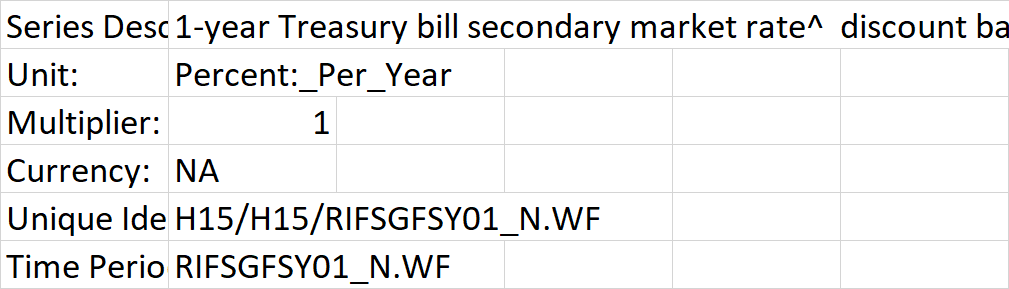

In [62]:
treasuries = pd.read_csv('data/Treasury Bills - 1 year maturity, weekly (secondary market)/FRB_H15.csv')
print(treasuries)
print(treasuries.info())
print(treasuries[treasuries.T_Rate == 'ND'])
treasuries = treasuries.iloc[2551:,:]
print(treasuries[treasuries.T_Rate == 'ND'])

            Date T_Rate
0      7/17/1959   4.51
1      7/24/1959   4.35
2      7/31/1959   4.23
3       8/7/1959   4.19
4      8/14/1959   4.19
...          ...    ...
3247   10/8/2021   0.09
3248  10/15/2021    0.1
3249  10/22/2021    0.1
3250  10/29/2021   0.12
3251   11/5/2021   0.15

[3252 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3252 non-null   object
 1   T_Rate  3252 non-null   object
dtypes: object(2)
memory usage: 50.9+ KB
None
           Date T_Rate
2198  8/31/2001     ND
2199   9/7/2001     ND
2200  9/14/2001     ND
2201  9/21/2001     ND
2202  9/28/2001     ND
...         ...    ...
2546   5/2/2008     ND
2547   5/9/2008     ND
2548  5/16/2008     ND
2549  5/23/2008     ND
2550  5/30/2008     ND

[351 rows x 2 columns]
Empty DataFrame
Columns: [Date, T_Rate]
Index: []


In [63]:
treasuries.Date = pd.to_datetime(treasuries.Date)
treasuries.T_Rate = pd.to_numeric(treasuries.T_Rate)
treasuries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 2551 to 3251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    701 non-null    datetime64[ns]
 1   T_Rate  701 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.1 KB


In [65]:
treasuries['Year'] = treasuries.Date.apply(lambda x : x.isocalendar()[0])
treasuries['Week'] = treasuries.Date.apply(lambda x : x.isocalendar()[1])
treasuries = treasuries.drop('Date', 1) # axis = 1, drop Date column
treasuries

,T_Rate,Year,Week
2551,2.08,2008,23
2552,2.42,2008,24
2553,2.48,2008,25
2554,2.37,2008,26
2555,2.27,2008,27
...,...,...,...
3247,0.09,2021,40
3248,0.10,2021,41
3249,0.10,2021,42
3250,0.12,2021,43


In [68]:
df8 = pd.merge(df7, treasuries,  how='left', left_on=['Year','Week'], right_on = ['Year','Week'])
print(df8.info())
df8 # correct number of rows (522), treasuries column properly added.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 0 to 521
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        522 non-null    int64  
 1   Week        522 non-null    int64  
 2   wk_return   522 non-null    float64
 3   avg_volume  522 non-null    float64
 4   wk_1        522 non-null    float64
 5   wk_2_5      522 non-null    float64
 6   wk_6_17     522 non-null    float64
 7   ff_rate     522 non-null    float64
 8   inflation   522 non-null    float64
 9   UNRATE      522 non-null    float64
 10  T_Rate      522 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 48.9 KB
None


,Year,Week,wk_return,avg_volume,wk_1,wk_2_5,wk_6_17,ff_rate,inflation,UNRATE,T_Rate
0,2020,5,-0.109456,5744680.0,-0.017619,0.008413,0.006058,1.55,1.6420,3.500,1.46
1,2020,4,-0.017619,2697350.0,0.004882,0.016863,0.001728,1.55,1.7100,3.500,1.51
2,2020,3,0.004882,2664840.0,0.011302,0.010032,0.000731,1.54,1.7560,3.500,1.50
3,2020,2,0.011302,2355880.0,0.006707,0.010858,0.003638,1.55,1.7480,3.500,1.50
4,2020,1,0.006707,2339300.0,0.010774,0.011394,0.003703,1.55,1.7725,3.500,1.53
...,...,...,...,...,...,...,...,...,...,...,...
517,2010,9,0.028459,2905180.0,-0.016756,0.001767,0.009093,0.13,2.1720,9.900,0.31
518,2010,8,-0.016756,3573740.0,0.036291,-0.012778,0.006298,0.12,2.1780,9.875,0.32
519,2010,7,0.036291,3158650.0,0.008228,-0.017622,0.009226,0.12,2.2725,9.850,0.35
520,2010,6,0.008228,4414500.0,-0.024257,-0.006677,0.009001,0.13,2.2680,9.825,0.34


In [67]:
import statsmodels.api as sm
X = df8.drop(columns = ['Year', 'Week', 'wk_return', 'ff_rate', 'inflation']) 
X = sm.add_constant(X)
y = df8.loc[:,"wk_return"] 
model = sm.OLS(y, X, data = df8) # create a model object

fit = model.fit() #fit our model
fit.summary()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              wk_return   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     10.34
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           7.85e-11
Time:                        01:55:58   Log-Likelihood:                 1181.6
No. Observations:                 522   AIC:                            -2349.
Df Residuals:                     515   BIC:                            -2319.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0142      0.006      2.241      0.0

# 11. Checking for Multicolinearity: Correlation Matrix and plots
- ## Create visualizations to explore the data
http://localhost:8888/notebooks/Code/_Metis/02%20-%20Linear%20Regression%20and%20Web%20Scraping/ON/02-LR_WS-10%20Linear%20Regression%20Exercises/regression_practice_solution.ipynb

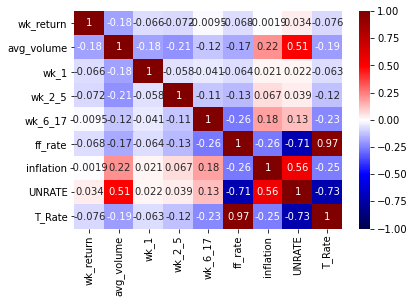

In [70]:
## Create visualizations to explore the data
import seaborn as sns

y_X_only = df8.drop(columns = ['Year','Week'])

# Plot the correlations between the variables
sns.heatmap(y_X_only.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

We already dropped ff_rate and inflation because the p-values were too high. The correlation matrix above gives us even more reason to drop ff_rate and inflation, and keep UNRATE.  
- The UNRATE is highly correlated (negatively) with ff_rate (-0.71)  
- The UNRATE is highly correlated (positively) with inflation (0.56)  
Multicolinearity refers to high correlation between the features used to model our target. We want to avoid this as it leads to lower p-values and weird parameters (coefficients) (i.e. magnitude and direction may not make sense).  

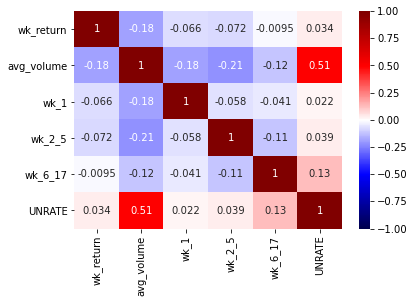

In [71]:
y_X_only = df8.drop(columns = ['Year','Week', 'ff_rate', 'inflation', 'T_Rate'])

# Plot the correlations between the variables
sns.heatmap(y_X_only.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

avg_volume is also highly correlated with UNRATE (0.51). Which one should we drop?  
avg_volume has a higher correlation to our target, wk_return (-0.18). adjusted R2 of 0.055 with avg_volume (drop UNRATE)
UNRATE only has a correlation of 0.034 with wk_return. adjusted R2 of 0.005 with UNRATE (drop avg_volume)
let's compare dropping UNRATE vs dropping avg_volume , all things being equal 

In [72]:
# X = df8.drop(columns = ['Year', 'Week', 'wk_return', 'ff_rate', 'inflation', 'T_Rate', 'avg_volume']) # remove avg_volume
X = df8.drop(columns = ['Year', 'Week', 'wk_return', 'ff_rate', 'inflation', 'T_Rate', 'UNRATE']) # remove UNRATE

X = sm.add_constant(X)
y = df8.loc[:,"wk_return"] 
model = sm.OLS(y, X, data = df8) # create a model object

fit = model.fit() #fit our model
fit.summary()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              wk_return   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     8.516
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           1.17e-06
Time:                        03:43:55   Log-Likelihood:                 1168.6
No. Observations:                 522   AIC:                            -2327.
Df Residuals:                     517   BIC:                            -2306.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.003      5.803      0.0

In [73]:
X = df8.drop(columns = ['Year', 'Week', 'wk_return', 'ff_rate', 'inflation', 'T_Rate', 'UNRATE', 'wk_6_17']) # remove WEEK_6_17

X = sm.add_constant(X)
y = df8.loc[:,"wk_return"] 
model = sm.OLS(y, X, data = df8) # create a model object

fit = model.fit() #fit our model
fit.summary()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              wk_return   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     10.75
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           7.32e-07
Time:                        03:44:30   Log-Likelihood:                 1167.7
No. Observations:                 522   AIC:                            -2327.
Df Residuals:                     518   BIC:                            -2310.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0185      0.003      5.646      0.0

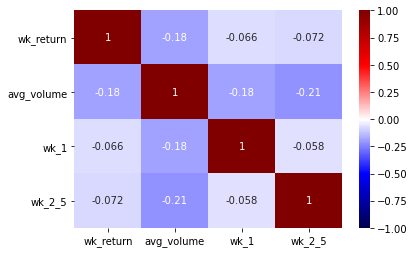

In [74]:
y_X_only = df8.drop(columns = ['Year','Week', 'ff_rate', 'inflation', 'UNRATE', 'T_Rate', 'wk_6_17'])

# Plot the correlations between the variables
sns.heatmap(y_X_only.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

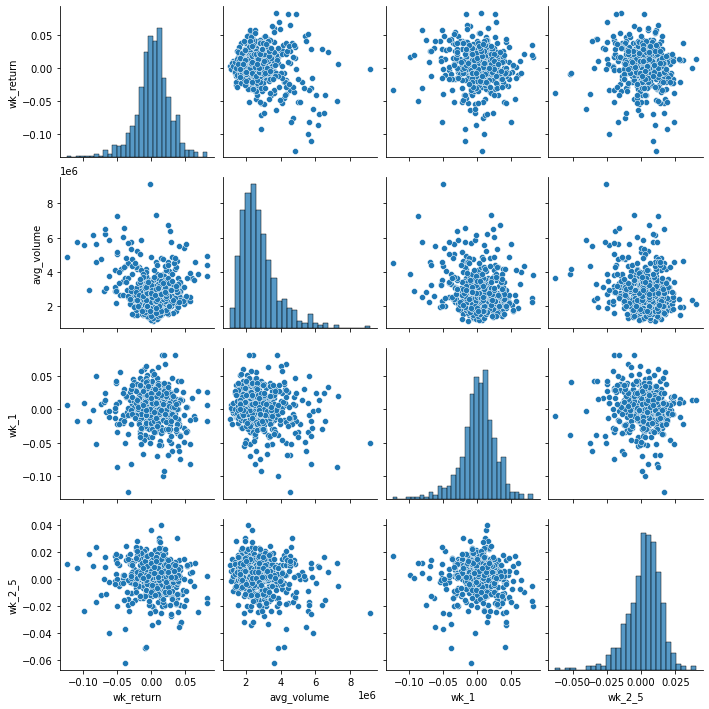

In [56]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(y_X_only);

# 12. Checking Linear Regression assumptions for avg_volume.
The average volume traded the week before looks like the most promising feature for this model. Let's examinine it more closely to see how well it adheres to the linear regression assumptions.

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

# the following function is taken from 'linear-assumptions-testing.ipynb' from the Linear Regression Assumptions and Evaluation lesson.

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

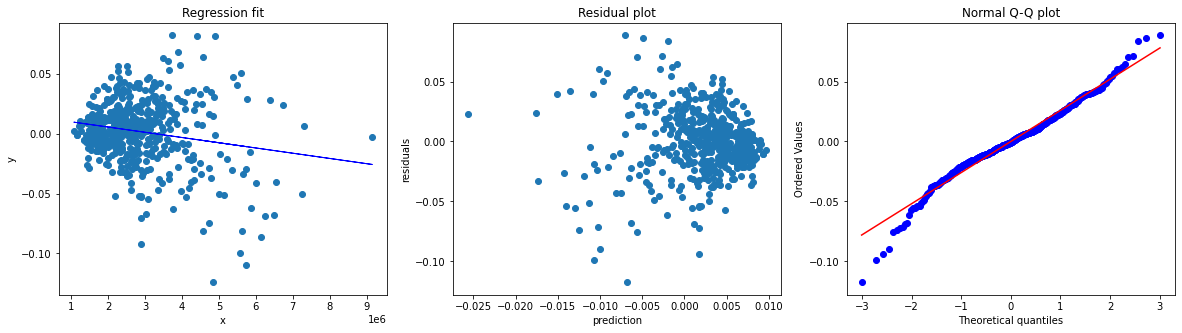

In [81]:
x = df8['avg_volume'].values
y = df8.loc[:,"wk_return"] 
type(x)
diagnostic_plot(x.reshape(522,1), y)

# 13. Cross Validation (80/20 training/test split)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# X, y = cars.drop('price',axis=1), cars['price']

# !!!! the module assumes no constant column so we need to redefine X so that it doesn't include constant
X = df7.drop(columns = ['Year', 'Week', 'wk_return', 'ff_rate', 'inflation', 'UNRATE', 'wk_6_17']) # remove WEEK_6_17
# X = sm.add_constant(X) # i.e. DO NOT RUN THIS
y = df7.loc[:,"wk_return"] 

# hold out 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10) # random_state, very important; make sure that ML algorithem, when ran again (with same data and maybe different parameters), makes sure that we're compairing apples to apple; random state is to seed the random numbers... 10 is the seed, can set it to any number I want. ensures that my work is repeatable on another person's computer. returns a tuple of 4 values. tuples are immutable.

In [59]:
lm = LinearRegression() # model 1, just vanilla LR; creating and instance (instanciating) a LinearRegression() object (sklearn); but we haven't done anything with it yet.

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler() #

X_train_scaled = scaler.fit_transform(X_train.values) # fits the scalar to the data and return it. standardize data and return a DF with all the data standardized. fit calculates mean and var for each column, then tranforms it = standardize it 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values) # doesn't have to be fitted for test

In [60]:
lm.fit(X_train, y_train) # fitting a LR model 
print(f'Linear Regression val R^2: {lm.score(X_test, y_test):.3f}') 

# .3f formatting of the score, another way of formatting the output of "score"; .3f want to have three places after decimal for the float; python string formatting; part of f'format'; 
# R2 for the test!
# this is different from the R2 that we were looking at earlier!! that was for the entire dataset... now we're just training on the trai set that was partitioned... THEN we're test it on the Test set, and seeing the R2 for that?

# test R2 (not adjusted) so we'd want to compare this R2 to the unadjusted from training set.

Linear Regression val R^2: 0.047


In [63]:
from sklearn.model_selection import KFold # What does Kfold mean? https://www.rousingdata.com/?p=19
# train/test split K-fold cross validation is a smaller split... K is how many to partition the data... 1 of them is testing, and the rest is for training. and then each partition will be the test in the the iteration. Not resplitting the data every time. Then will average the scores on each of them. gives the estimate of how...
# simple test/training.... only does 1 split...

In [64]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71) # 5 fold x-validation; shuffle the dataset before splitting, random state is the seed. we're just creating an instance of KFold... haven't fed in the data yet.
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_val_scaled = scaler.transform(X_val)
    
#     lm_reg.fit(X_train_scaled, y_train)
#     cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
# print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
# print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

KeyError: "None of [Int64Index([  1,   2,   4,   5,   7,   8,   9,  10,  11,  12,\n            ...\n            508, 509, 510, 511, 512, 513, 514, 517, 518, 521],\n           dtype='int64', length=417)] are in the [columns]"

In [95]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cv_R2 = cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
print(f"5-fold cross validation R2: {np.round(cv_R2,3)}")
print(f"5-fold cross validation avg. R2: {np.round(np.mean(cv_R2), 3)}")

# look at RMSE?
# how do I set seed for this?
# do it 30 times and boxplot?

# ‘neg_root_mean_squared_error’

cv_RMSE = cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error') # scoring metric
print(cv_RMSE) # in the case of negative, my model is performing worse than average. classfication is useful but in regression is useless. Avg is better.
print(f"5-fold cross validation RMSE's: {-1*np.round(cv_RMSE, 3)}")
print(f'5-fold cross validation RMSE mean: {-1*np.round(np.mean(cv_RMSE), 3)}')

# - to calculate RMSE, scoring parameter is changed from r2 to ‘neg_root_mean_squared_error’. Why are all the RMSE’s calculated negative? This is a quirk in data science and scikitlearn
# --> all of scikit learn models are trying to maximize things (e.g. scoring = ‘accuracy’) ...but error is something that we want to minimize. So we maximize negative error. neg_root_mean_squared_error is simply the negative of RMSE. RMSE is always positive.
# --> just need to multiply neg_root_mean_squared_error calculated by -1.

5-fold cross validation R2: [ 0.041 -0.16  -0.075 -0.068 -0.012]
5-fold cross validation avg. R2: -0.055
[-0.03526007 -0.02053385 -0.02343274 -0.01966629 -0.03106556]
5-fold cross validation RMSE's: [0.035 0.021 0.023 0.02  0.031]
5-fold cross validation RMSE mean: 0.026


In [78]:
#### not necessary to repeatedly do 5-fold cv using different seeds...
## BUT... what's wrong here? why are the r2 values all of a sudden so good when we use scikitlearn instead of statsmodels?

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, KFold
import statistics as stats
import random
import numpy as np

# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
# print(X)
# print(y)


CVScores = []
for i in range(0, 3):
    kf = KFold(n_splits=5, shuffle=True, random_state=i)
    kf.get_n_splits(X)
    
    lm = LinearRegression()
    lm.fit(X,y)
#     ada = AdaBoostClassifier(n_estimators=100)
#     ada.fit(X, y)
    CVScores.extend(list(cross_val_score(lm, X, y, cv=kf, scoring="r2")))
print(CVScores)
mean = stats.mean(CVScores)
print(mean)

[0.6905870737416401, 0.7470637147528403, 0.7077248083785184, 0.6658850718288523, 0.6180339058825182, 0.6839627965834338, 0.6848185540337977, 0.7286134327730796, 0.6919554796414042, 0.6463344698245224, 0.7469226566177337, 0.6765740899746412, 0.6486871016836626, 0.6778372608648149, 0.6888252714023415]
0.6869217125322534


In [74]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

# MARKER 1: ABOVE IS THE END OF WHAT I'M WORKING ON RIGHT NOW 
# MARKER 1: ABOVE IS THE END OF WHAT I'M WORKING ON RIGHT NOW 
# MARKER 1: ABOVE IS THE END OF WHAT I'M WORKING ON RIGHT NOW 

In [126]:
h = np.arange(10).reshape(2,5)
h

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [128]:
h.sum()

45

In [237]:
# turn multi-index into columns and name column as weekly return
df4 = df4.reset_index()
df4.rename(columns={df4.columns[2]: "wk_return"}, inplace = True)
df4

,Year,Week,wk_return
0,2011,1,-0.258559
1,2011,2,-0.233318
2,2011,3,-0.241689
3,2011,4,-0.268804
4,2011,5,-0.250995
...,...,...,...
463,2019,48,-0.050692
464,2019,49,-0.050717
465,2019,50,-0.061334
466,2019,51,-0.022079


In [ ]:
create two new columns in dataframe
1. year
series.dt.year

2. woy
series.dt.week

df.groupby('year','woy').apply(return_func)
def return_func(df):
    
    

In [3]:
from yahoo_finance import Share

MMM = Share('MMM')

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [6]:
import yfinance as yf

msft = yf.Ticker("MSFT")

msft.earnings
msft.quarterly_earnings

,Revenue,Earnings
Quarter,,
4Q2020,43076000000,15463000000
1Q2021,41706000000,15457000000
2Q2021,46152000000,16458000000
3Q2021,45317000000,20505000000


### Let's add a couple of categorical variables, "Sector" and "Sub_Sector" to the DF using the snp df created from the SP500 Wikipedia page

In [88]:
# recall snp DF was taken from the Wikipedia page for SP500: 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

snp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 505 non-null    object
 1   Security               505 non-null    object
 2   SEC filings            505 non-null    object
 3   GICS Sector            505 non-null    object
 4   GICS Sub-Industry      505 non-null    object
 5   Headquarters Location  505 non-null    object
 6   Date first added       457 non-null    object
 7   CIK                    505 non-null    int64 
 8   Founded                505 non-null    object
dtypes: int64(1), object(8)
memory usage: 35.6+ KB


In [97]:
snp[snp.Symbol == "MMM"]['GICS Sector']

# 0    Industrials
# Name: GICS Sector, dtype: object 

# this looks like a series... We know because it gives a name associated with it. Also we have a index 0.. so it's a series with 1 element.

0    Industrials
Name: GICS Sector, dtype: object

In [119]:
snp[snp.Symbol == "MMM"]['GICS Sector'][0]

'Industrials'

In [98]:
industry = snp[snp.Symbol == "MMM"]['GICS Sector'][0]
df['Sector'] = industry

In [103]:
sub_industry = snp[snp.Symbol == "MMM"]['GICS Sub-Industry']
snp[snp.Symbol == "MMM"]['GICS Sub-Industry'][0] # again, a series with 1 element

0    Industrial Conglomerates
Name: GICS Sub-Industry, dtype: object

In [104]:
df['Sub_Sector'] = sub_industry[0]

In [105]:
df

# (Adj_Close-end - Adj_Close-beginning) / Adj_Close-Beginning

,Date,Open,High,Low,Close,Adj_Close,Volume,Sector,Sub_Sector
0,2021-11-01,178.53,179.74,177.51,179.58,179.58,2010500,Industrials,Industrial Conglomerates
1,2021-10-29,179.71,180.91,178.12,178.68,178.68,2559500,Industrials,Industrial Conglomerates
2,2021-10-28,178.25,180.01,178.24,179.87,179.87,1944900,Industrials,Industrial Conglomerates
3,2021-10-27,182.27,182.34,178.08,178.24,178.24,2627000,Industrials,Industrial Conglomerates
4,2021-10-26,181.07,183.82,179.17,182.16,182.16,3135600,Industrials,Industrial Conglomerates
...,...,...,...,...,...,...,...,...,...
13071,1970-01-08,7.00,7.11,6.98,7.09,1.50,304000,Industrials,Industrial Conglomerates
13072,1970-01-07,6.96,7.02,6.95,7.00,1.48,164800,Industrials,Industrial Conglomerates
13073,1970-01-06,6.89,6.96,6.88,6.96,1.47,176000,Industrials,Industrial Conglomerates
13074,1970-01-05,6.86,6.90,6.86,6.89,1.46,446400,Industrials,Industrial Conglomerates


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13076 entries, 0 to 13075
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        13076 non-null  datetime64[ns]
 1   Open        13076 non-null  float64       
 2   High        13076 non-null  float64       
 3   Low         13076 non-null  float64       
 4   Close       13076 non-null  float64       
 5   Adj_Close   13076 non-null  float64       
 6   Volume      13076 non-null  int64         
 7   Sector      13076 non-null  category      
 8   Sub_Sector  13076 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(5), int64(1)
memory usage: 741.0 KB


In [113]:
# ??? should we keep sector and sub-sectors as str or 'category' dtype?
df['Sector'] = df['Sector'].astype('category')
df['Sub_Sector'] = df['Sub_Sector'].astype('category')

In [127]:
# Let's go back to snp (not just MMM, all 505 stocks)

# What are the sub-sectors? how many?

print(snp['GICS Sub-Industry'].value_counts())
print(snp['GICS Sub-Industry'].unique())
print(len(snp['GICS Sub-Industry'].unique())) # 124 unique subsectors in SP500
# too many subsectors to be grouping stocks by, how about sectors?

Health Care Equipment                   19
Semiconductors                          14
Application Software                    14
Electric Utilities                      13
Industrial Machinery                    13
                                        ..
Food Distributors                        1
Brewers                                  1
Thrifts & Mortgage Finance               1
Food Retail                              1
Human Resource & Employment Services     1
Name: GICS Sub-Industry, Length: 124, dtype: int64
['Industrial Conglomerates' 'Health Care Equipment' 'Pharmaceuticals'
 'IT Consulting & Other Services' 'Interactive Home Entertainment'
 'Application Software' 'Semiconductors' 'Automotive Retail'
 'Independent Power Producers & Energy Traders' 'Life & Health Insurance'
 'Industrial Gases' 'Internet Services & Infrastructure' 'Airlines'
 'Specialty Chemicals' 'Office REITs' 'Health Care Supplies'
 'Building Products' 'Electric Utilities' 'Property & Casualty Insurance'
 

In [130]:
print(snp['GICS Sector'].unique())
print(len(snp['GICS Sector'].unique())) # only 11 sectors # could be a categorical variable

['Industrials' 'Health Care' 'Information Technology'
 'Communication Services' 'Consumer Discretionary' 'Utilities'
 'Financials' 'Materials' 'Real Estate' 'Consumer Staples' 'Energy']
11


# Extra below

In [39]:
# when do i want to .copy() on a DF? If i don't want to change original DF.

df2 = df.copy()
df2['test2'] = 2
df
df2

,Date,Open,High,Low,Close,Adj_Close,Volume,Sector,test,test2
464,2019-12-30,177.26,178.96,175.59,175.83,165.64,1715100,Industrials,0,2
465,2019-12-27,176.65,177.54,175.62,177.26,166.99,1472900,Industrials,0,2
466,2019-12-26,176.45,176.66,175.50,176.59,166.36,1435200,Industrials,0,2
467,2019-12-24,178.27,178.67,176.04,176.68,166.44,1259500,Industrials,0,2
468,2019-12-23,176.71,179.18,176.56,178.47,168.13,4876300,Industrials,0,2
...,...,...,...,...,...,...,...,...,...,...
2722,2011-01-07,86.55,87.31,85.95,86.23,64.32,3355500,Industrials,0,2
2723,2011-01-06,86.86,87.19,85.63,86.14,64.26,3452600,Industrials,0,2
2724,2011-01-05,86.29,87.90,86.12,86.67,64.65,4081300,Industrials,0,2
2725,2011-01-04,87.00,87.28,86.28,86.67,64.65,2644100,Industrials,0,2


In [40]:
df['Week'] = 0

<ipython-input-40-10a1d99a8638>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = 0


In [41]:
df['Year'] = 0

<ipython-input-41-9b35e33d9f31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = 0


In [ ]:
def (df, start_date, end_date):
    sortby date... and index(1).
    
